In [3]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

import urllib.request
LABELS_URL = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
class_names = urllib.request.urlopen(LABELS_URL).read().decode('utf-8').splitlines()

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='DEFAULT')
model.eval()

Using cache found in /Users/krishuagarwal/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
gradients = []
activations = []

def save_gradient(module, grad_input, grad_output) : 
    gradients.append(grad_output[0])
    
def save_activation(module, input, output):
    activations.append(output)
    
final_conv = model.layer4[-1] # last layer activations and gradients
final_conv.register_forward_hook(save_activation)
final_conv.register_backward_hook(save_gradient)

In [ ]:
# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
img_path = 'input/Chihuahua.jpg'  # Replace with your image path
img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0) # Add an extra dimension

In [18]:
def calculate_grad_cam(gradients, activations) : 
    grads_val = gradients[0].squeeze(0).detach().numpy()
    acts_val = activations[0].squeeze(0).detach().numpy()
    
    weights = grads_val.mean(axis=(1,2)) # average pooling over the Height and Width
    cam = np.zeros(acts_val.shape[1:], dtype=np.float32)
    
    # using the weights of the gradients we are calculating the weighted combination of gradients
    for i, w in enumerate(weights) : 
        cam += w * acts_val[i]
        
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224)) # this is important, as the activations are not the same size as the input image
    cam -= cam.min()
    cam /= cam.max() + 1e-8  # Avoid division by zero
    return cam

def extract_bounding_boxes(cam, img, threshold=0.3):
    """
    Extract bounding boxes from the Grad-CAM heatmap and draw them on the image.
    You can adjust the threshold to control the sensitivity of the bounding box extraction.
    The higher the threshold, the fewer boxes will be detected.
    """
    # Convert the Grad-CAM heatmap to an 8-bit image
    heatmap = (cam * 255).astype(np.uint8)
    # Apply a binary threshold to the heatmap to isolate the most salient regions
    _, binary_map = cv2.threshold(heatmap, threshold * 255, 255, cv2.THRESH_BINARY)

    # Find contours in the binary map to detect connected regions
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Resize the original image to match the Grad-CAM heatmap size (224x224)
    img_np = np.array(img.resize((224, 224)))

    # Collect bounding boxes
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        boxes.append([x, y, x + w, y + h])  # [x1, y1, x2, y2]

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_np, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img_np

Predicted class: 151 - Chihuahua


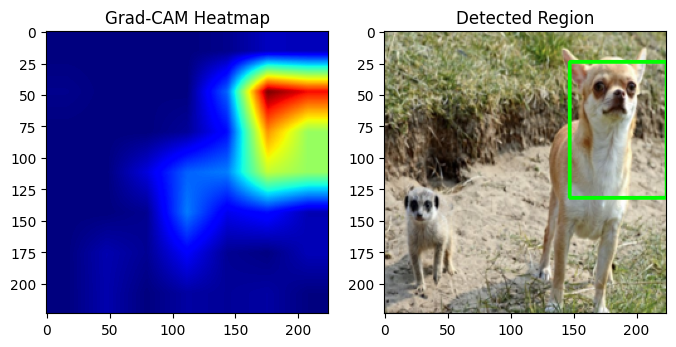

In [27]:
output = model(input_tensor)
pred_class = output.argmax().item() # id of the predicted class

print(f"Predicted class: {pred_class} - {class_names[pred_class]}")

# Backward pass to get gradients for the predicted class
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward() # loss with respect to the class

cam = calculate_grad_cam(gradients, activations)
bounding_box = extract_bounding_boxes(cam, img)

# Show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 2, 2)
plt.imshow(bounding_box)
plt.title("Detected Region")
plt.show()


### Task 2

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='DEFAULT')
final_conv = model.layer4[-1] # last convolutional layer. 

activations = []
def save_activations(module, input, output) : 
    activations.append(output)
    
final_conv.register_forward_hook(save_activation) # Saving the activations

Using cache found in /Users/krishuagarwal/.cache/torch/hub/pytorch_vision_v0.10.0


In [32]:
img_path = 'input/Bulldog.png'  # Replace with your image path
img = Image.open(img_path).convert('RGB')        # Ensure RGB format
input_tensor = preprocess(img).unsqueeze(0)    

activations.clear()
final_conv.register_forward_hook(save_activation) # Saving the activations

In [37]:
with torch.no_grad() : 
    output = model(input_tensor)
    
topk = 2
top_classes = output[0].topk(topk).indices.tolist()

feature_map = activations[0].squeeze(0)
fc_weights = model.fc.weight.data # getting the fully connected weights

segmentation = np.zeros((224, 224), dtype=np.uint8)      # Final segmentation labels per pixel
overlay = np.zeros((224, 224, 3), dtype=np.uint8)  
class_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]       

In [45]:
weights = fc_weights[top_classes[0]]
cam = torch.einsum('c,chw->hw', weights, feature_map) # reweighting activations with fc weights of that class
cam = cam.cpu().numpy()
cam = np.maximum(cam, 0) # RELU
cam -= cam.min()
cam /= cam.max() + 1e-8

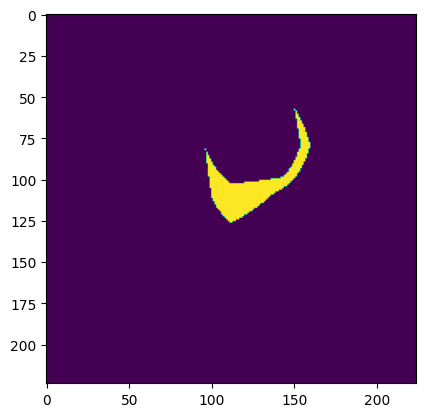

In [48]:
cam = cv2.resize(cam, (224,224))
mask = cam > 0.5
segmentation[mask] = 0
plt.imshow(segmentation)